In [1]:
from typing import List

import numpy as np
import torch as t
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

/Users/Jesse/.virtualenvs/notes/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

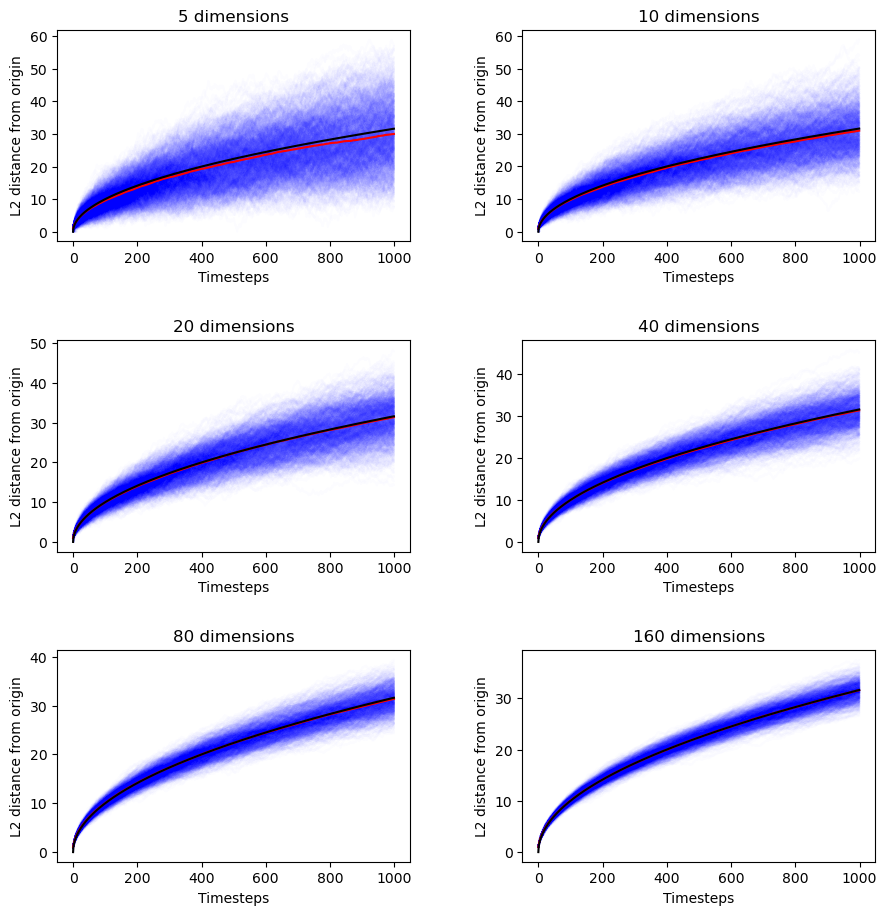

In [24]:
def random_hyperwalk(n_dims: int, n_samples: int = 1_000, n_timesteps: int = 10_000) -> np.ndarray:
    state = np.zeros((n_samples, n_dims))
    distances = np.zeros((n_samples, n_timesteps))

    for t in tqdm(range(n_timesteps)):
        step = np.random.choice(np.arange(n_dims), n_samples)
        # print(step)
        directions = np.random.choice([-1, 1], n_samples)
        # print(directions)

        # TODO: vectorize this
        for i in range(n_samples):
            state[i, step[i]] += directions[i]

        # print(step, directions, state[:, step])
        distances[:, t] = np.linalg.norm(state, axis=1)

    return distances

def random_hyperwalk_scaling(n_dim_range: List[int], n_samples: int = 1_000, n_timesteps: int = 10_000):
    timesteps = np.arange(n_timesteps)
    predictions = np.sqrt(timesteps)
    trajectories = np.zeros((len(n_dim_range), n_samples, n_timesteps))

    fig, ax = plt.subplots(len(n_dim_range) // 2, 2, figsize=(10, 10))
    fig.tight_layout(pad=5.0)

    for I, n_dims in enumerate(n_dim_range):
        i, j = I // 2, I % 2

        trajectories[I, :, :] = random_hyperwalk(n_dims, n_samples, n_timesteps)
        mean_distances = np.mean(trajectories[I, :, :], axis=0)

        for k in range(n_samples):
            ax[i][j].plot(timesteps, trajectories[I, k, :], color="blue", alpha=0.01)
    
        ax[i][j].set_title(f"{n_dims} dimensions")
        ax[i][j].plot(timesteps, mean_distances, color="red")
        ax[i][j].plot(timesteps, predictions, color="black")
        ax[i][j].set_xlabel("Timesteps")
        ax[i][j].set_ylabel("L2 distance from origin")

    plt.show()


random_hyperwalk_scaling([5, 10, 20, 40, 80, 160], n_samples=1000, n_timesteps=1000)

In [ ]:

def n_params(n_hidden: int, width: int, n_in = 784, n_out = 10) -> int:
    """Returns the number of parameters in a feedforward neural network"""
    return (n_in + 1) * width + (n_hidden) * (width + 1) * width + (width + 1) * n_out 


In [ ]:

def plot_metric_panel() -> Tuple[Figure, List[List[plt.Axes]]]:
    def plot_panel(
        self,
        df: pd.DataFrame,
        comparison: str,
        metrics: List[str],
        step: Optional[int] = None,
        epoch: Optional[int] = None,
        batch_idx: Optional[int] = None,
        overwrite: bool = False,
        **details,
    ):
        """Plots a panel of the given metrics for the given hyperparameter"""

        series = df

        baseline = series[series["epsilon"] == 0.0]

        # Filter the series
        for k, v in details.items():
            series = series[series[k] == v]
            details[k] = v

            if k != "epsilon":
                baseline = baseline[baseline[k] == v]

        # Stable order
        details = {k: v for k, v in sorted(details.items())}
        details_rep = dict_to_latex(details)

        if step is not None:
            series = series[series["step"] <= step]
            baseline = baseline[baseline["step"] <= step]
        else:
            step = series["step"].max().item()

        comparison_values = series[comparison].unique()

        # Check if the figure already exists
        img_dir = self.dir / "img"
        img_dir.mkdir(parents=True, exist_ok=True)
        filepath = img_dir / f"{step}_{comparison}_{stable_hash(details_rep)}.png"

        if filepath.exists() and not overwrite:
            return

        # Create a new figure
        fig, axes = plt.subplots(
            len(metrics) // 2, 2, figsize=(5 * 2, len(metrics) * 5 // 3)
        )
        fig.tight_layout(pad=5.0)

        fig.suptitle(
            f"Comparison over ${var_to_latex(comparison)}$\\ ($t\leq{step}, {details_rep}$)"
        )

        average = series.groupby("step").mean().reset_index()

        # Plot each metric
        for i, metric in enumerate(metrics):
            ax = axes[i // 2][i % 2]

            plot_baseline = metric in [
                "L_train",
                "acc_train",
                "L_test",
                "acc_test",
            ]

            # Plot the baseline
            if plot_baseline:
                ax.plot(
                    baseline["step"], baseline[metric], label="baseline", color="black"
                )

            # Plot the average
            ax.plot(average["step"], average[metric], label="average", color="red")

            # Plot the other models
            for comparison_value in comparison_values:
                df_for_value = series[series[comparison] == comparison_value]

                comparison_label = f"${var_to_latex(comparison)}={comparison_value}$"

                if comparison == "seed_perturbation":
                    comparison_label = f"_{comparison_value}"  # Hidden from legend

                ax.plot(
                    df_for_value["step"],
                    df_for_value[metric],
                    label=comparison_label,
                    alpha=0.25,
                )

            metric_rep = f"${var_to_latex(metric)}$"
            ax.set_title(metric_rep)
            ax.set_xlabel("step")
            ax.set_ylabel(metric_rep)
            ax.legend()

        # Save the figure
        # splt.show()

        print(f"Saving figure to {filepath}")
        fig.savefig(filepath)  # type: ignore

    def plot(
        self,
        step: Optional[int] = None,
        epoch: Optional[int] = None,
        batch_idx: Optional[int] = None,
    ):
        df = self.df()
        comparisons = self.comparisons

        for comparison in comparisons:
            # Plot a panel over a single comparison hyperparameter
            # for all possible other hyperparams held fixed

            other_comparisons: List[str] = [c for c in comparisons if c != comparison]
            other_hp_combos: Iterable[Tuple[Any, ...]] = itertools.product(
                *[getattr(self, hp) for hp in other_comparisons]
            )

            for hp_combo in other_hp_combos:
                details = dict(zip(other_comparisons, hp_combo))

                self.plot_panel(
                    df,
                    comparison,
                    metrics=self.metrics.keys(),
                    step=step,
                    epoch=epoch,
                    batch_idx=batch_idx,
                    **details,
                )

                if comparison in ("epsilon", "momentum", "lr", "weight_decay"):
                    # We only want to plot the panel over epsilon for one choice of seed perturbation
                    break



In [2]:

def tensor_map_1(f, *args):
    return t.stack([f(*arg) for arg in zip(*args)])

def tensor_map_2(f, *args):
    return t.tensor([f(*arg) for arg in zip(*args)])


print(
    tensor_map_1(lambda x: x**2, [1, 2, 3, 4]),
    tensor_map_2(lambda x: x**2, [1, 2, 3, 4])
)



TypeError: expected Tensor as element 0 in argument 0, but got int

TypeError: arange(): argument 'end' (position 1) must be Number, not tuple

TypeError: arange() missing 1 required positional arguments: "end"

tensor([[ 2, 12, 22, 32],
        [ 4, 14, 24, 34],
        [ 6, 16, 26, 36],
        [ 8, 18, 28, 38]])

In [6]:
_.shape

torch.Size([4, 4])

tensor([[ 2, 12, 22, 32],
        [ 4, 14, 24, 34],
        [ 6, 16, 26, 36],
        [ 8, 18, 28, 38],
        [ 7, 17, 27, 37]])

torch.Size([5, 4])